# Python Spatial Analysis and Mapping

Agenda:
- python spatial analysis with geopandas
- projecting lat-long spatial data and shapefiles
- mapping with basemaps

### Quick overview of mapping and projections

##### Some terminology:
- **geoid**: (that's *gee-oid*) the surface of the earth's gravity field, which approximates mean sea level
- **spheroid** or **ellipsoid** (interchangeable terms): a model that smoothly approximates the geoid
- **datum**: based on spheroid but incorporates local variations in the shape of the Earth. Used to describe a point on the Earth's surface, such as in latitude and longitude.
  - NAD83 (North American Datum 1983) uses the GRS80 spheroid
  - WGS84 (World Geodetic Survey 1984 datum) uses the WGS84 spheroid
  - The latitude and longitude coordinates of some point differ slightly based on the datum. GPS uses WGS84.
- **coordinate reference system** (CRS) or spatial reference system (SRS): a series of parameters that [define](http://spatialreference.org/) the coordinate system and spatial extent (aka, domain) of some dataset.
- **geographic coordinate system** (GCS): specifies a datum, spheroid, units of measure (such as meters), and a prime meridian
- **projected coordinate system** or map projection: projects a map of the Earth's 3-D spherical surface onto a flat surface that can be measured in units like meters. Here's a [list of projections](http://www.remotesensing.org/geotiff/proj_list/).
- **eastings** and **northings**: the x and y coordinates of a projected map, usually measured in meters
- **false origin**: the 0,0 origin point from which eastings and northings are measured on the map, usually the lower left corner rather than the center
- **PROJ.4**: a library to convert/project spatial data with consistent CRS [parameter names](https://github.com/OSGeo/proj.4/wiki/GenParms)

##### Common CRS parameters (and their PROJ.4 names):
- datum (datum)
- ellipse (ellps)
- projection (proj)
  - the name of the projected coordinate system, such as Albers Equal Area (aea) or Lambert Conformal Conic (lcc)
- standard parallels (lat_1, lat_2)
  - where the projection surface touches the globe - at the standard parallels, the projection shows no distortion
- central meridian and latitude of origin (lon_0, lat_0)
  - the origin of the projection's x and y coordinates (eastings and northings) - usually the center of the map projection
- false easting and false northing (x_0, y_0)
  - offsets to add to all your eastings and northings - usually used to make all the coordinates on the map positive numbers by starting 0,0 at the lower left corner rather than the center of the map (see false origin, above)

##### Common projection types:
- *equal area* projections: maintain area at the expense of shape, distance, and direction - such as the [Albers Equal Area](http://www.remotesensing.org/geotiff/proj_list/albers_equal_area_conic.html) projection
- *conformal* projections: maintain shapes at the expense of area, distance, and direction - such as the [Lambert Conformal Conic](http://www.remotesensing.org/geotiff/proj_list/lambert_conic_conformal_2sp.html) projection
- *equidistant* projections: preserve distance from one point or along all meridians and parallels
- *azimuthal* projections: maintain direction from one point to all other points - such as an [orthographic](http://www.remotesensing.org/geotiff/proj_list/orthographic.html) projection
- others compromise to minimize overall distortion or aim for aesthetic value - such as the [Robinson](https://upload.wikimedia.org/wikipedia/commons/9/96/Robinson_projection_SW.jpg) projection

In [1]:
# magic command to display matplotlib plots inline within the ipython notebook
%matplotlib inline

# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point
from geopy.distance import great_circle

## Part 1: spatial analysis
We'll use [geopandas](http://geopandas.org/user.html), which spatializes pandas dataframes. 

In [2]:
# load the states shapefile as a geodataframe
df = GeoDataFrame.from_file('2010Census_Blockgrp_NAD83Alb_nowater_OaklandOnly_v2.shp')
df.head()

,ACTransCt,ACTransThr,ALAND10,AWATER10,AmtrakThr,AreaPDA,AreaTot,Avg_Slope,BLKGRPCE10,BartThr,...,sc_resgrow,sc_resil,sc_thilulo,schldist_z,schooldist,socservdis,sservdis_z,studyarea,tlu_sum_hi,tlu_sum_lo
0,15,1,274258,0,0,0.000000,274259.442813,1.860736,1,0,...,0.504,0.364,1.059700,-0.157886,375.996328,3952.247681,0.733914,1,0.2620,0.8550
1,34,1,313288,0,0,313286.960126,313286.960126,1.870402,2,0,...,1.211,0.349,0.946268,-0.601396,244.158318,2019.437308,-0.572494,1,0.5130,0.7205
2,37,1,408625,0,0,0.000000,408623.944423,2.235017,2,0,...,0.527,0.420,1.059700,0.316204,516.924971,2984.298144,0.079666,1,0.1215,0.8595
3,31,1,456611,0,0,456613.001079,456613.001079,0.197073,3,0,...,1.094,0.468,1.468656,-0.647201,230.542307,1507.096239,-0.918791,1,0.5550,0.5785
4,20,1,202348,0,0,194979.434091,202348.036619,0.312476,4,0,...,1.020,0.468,1.161193,0.021384,429.286512,1904.773627,-0.649997,1,0.3295,0.6830


In [3]:
df = df[['geometry', 'ix_auto_p', 'ix_buvi_p', 'ix_disad_p', 'ix_fupo_p', 
        'ix_luco_p', 'ix_lufe_p', 'ix_res_p', 'ix_tcco_p', 'ix_tcfe_p', 'sc_all']]
df.head()

,geometry,ix_auto_p,ix_buvi_p,ix_disad_p,ix_fupo_p,ix_luco_p,ix_lufe_p,ix_res_p,ix_tcco_p,ix_tcfe_p,sc_all
0,POLYGON ((-192892.7870152284 -20995.4129560068...,0.232,0.328358,0.158,0.140,0.143283,0.856716,0.364,0.313432,0.916417,1.041358
1,POLYGON ((-192470.6670469679 -23560.1336824446...,0.122,0.125373,0.367,0.862,0.247761,0.752238,0.349,0.704477,0.698507,1.339173
2,POLYGON ((-192186.7032789606 -22294.1540910815...,0.298,0.394029,0.176,0.107,0.149253,0.850746,0.420,0.032835,0.910447,1.208629
3,POLYGON ((-191100.1358752354 -28694.7773851258...,0.755,0.453731,0.659,0.626,0.698507,0.301492,0.468,0.340298,0.770149,2.505031
4,POLYGON ((-190978.7738020942 -29418.8835500078...,0.707,0.017910,0.513,0.552,0.370149,0.629850,0.468,0.116417,0.791044,1.845410


In [4]:
df.crs

{u'datum': u'NAD83',
 u'lat_0': 0,
 u'lat_1': 34,
 u'lat_2': 40.5,
 u'lon_0': -120,
 u'no_defs': True,
 u'proj': u'aea',
 u'units': u'm',
 u'x_0': 0,
 u'y_0': -4000000}

Let's define a projection we can use to convert and map our lat-long data. The parameters in the following dictionaries correspond to the projection parameters from PROJ4. Geopandas uses the pyproj library to convert spatial data, which in turn uses PROJ4 projection names and parameters.

You can figure out these parameter values either by approximating the lats and longs of your spatial data set, or by trial and error, or by looking up a reference like [this one](http://spatialreference.org/ref/epsg/26911/) for UTM zone 11. 

Geopandas needs your projection to be specified in a dict - you can create one manually, or use the function below to convert a PROJ4 string to a dict.

In [5]:
# option 2: pass an existing proj4 string to this function and it'll turn it into a python dict
def proj4_to_dict(proj4string):
    params_dict = {}
    proj4string = proj4string.strip('+') #strip preceding +
    for param_pair in proj4string.split(' +'): #break string into tokens
        key_value = param_pair.split('=') #break token by parameter=value
        if len(key_value)==2: #if there aren't 2 pieces (param and value), ignore it
            key, value = tuple(key_value)
        params_dict[key] = value
    return params_dict

In [6]:
# test the function out
proj4 = '+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext  +no_defs'
web_mercator = proj4_to_dict(proj4)
web_mercator

{'a': '6378137',
 'b': '6378137',
 'k': '1.0',
 'lat_ts': '0.0',
 'lon_0': '0.0',
 'nadgrids': '@null',
 'proj': 'merc',
 'units': 'm',
 'x_0': '0.0',
 'y_0': '0'}

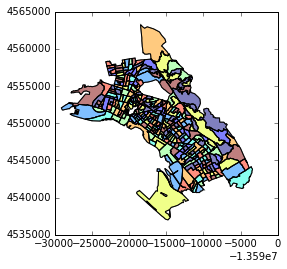

In [7]:
# the california shapefile already has an original CRS so we don't need to specify it - just project and plot it
# the original CRS lives in the .prj file in the states directory! GeoDataFrame.from_file automatically goes and looks for it.
df = df.to_crs(web_mercator)
df.plot()

In [9]:
df.crs

{'a': '6378137',
 'b': '6378137',
 'k': '1.0',
 'lat_ts': '0.0',
 'lon_0': '0.0',
 'nadgrids': '@null',
 'proj': 'merc',
 'units': 'm',
 'x_0': '0.0',
 'y_0': '0'}

So that's our projected data and shapefile. Notice how the shape has changed, and how the units make more sense - they are in meters now. So our buffers are a 30km radius from each point.

It's also easy to save a geodataframe as a shapefile or as a geojson string (for easy leaflet mapping):

In [10]:
# convert un-projected point data and shapefile to geojson strings (you can then copy/paste these or save them to a file)
df_geojson = df.to_json()
df_geojson[:10]

'{"type": "'

In [11]:
# save the geojson result to a file
output_filename = 'oakland.js'
with open(output_filename, 'wb') as output_file:
    output_file.write('var dataset = ')
    output_file.write(df_geojson)


Now let's project our entire USA points data to a projection appropriate for the entire USA. We'll specify the datum, ellipsoid, projection name, standard parallels, central meridian and latitude of origin, false easting and false northing (because matplotlib basemap sticks the origin at the lower left corner), and measurement units. 

In [ ]:
# set our usa_points dataset's original CRS
usa_points.crs = original_crs
usa_points.head()

In [ ]:
# specify the width and height of the map extent/domain in projection coordinate units (meters) - approx USA dimensions
# this is so the projected data will line up with the basemap
map_width_m = 5000 * 1000 #5000 km
map_height_m = 3500 * 1000 #3500 km

In [ ]:
# Albers Conical Equal Area projection for USA
# we actually made up many of these numbers! So it is possible to neatly tailor an 
# Albers Equal Area projection for our specific needs - though possibly better not to,
# for consistency with the rest of the world
albers_usa = {'datum':'NAD83',
              'ellps':'GRS80',
              'proj':'aea', 
              'lat_1':33, 
              'lat_2':45, 
              'lon_0':-97, 
              'lat_0':39, 
              'x_0':map_width_m/2, 
              'y_0':map_height_m/2,
              'units':'m'}

In [ ]:
# now you can convert the point data to a projected CRS
target_crs = albers_usa
usa_points = usa_points.to_crs(target_crs)
usa_points.head()

In [ ]:
# convert the projected points into discrete x and y columns for easy matplotlib scatter-plotting
usa_points['x'] = usa_points['geometry'].map(lambda point: point.x)
usa_points['y'] = usa_points['geometry'].map(lambda point: point.y)
usa_points.head()

In [ ]:
# scatter plot un-projected and projected point data side by side
fig, ax = plt.subplots(1, 2, figsize=[15,4])
ax[0].scatter(x=usa_points['longitude'], y=usa_points['latitude'], c='g', edgecolor='None', alpha=0.4)
ax[1].scatter(x=usa_points['x'], y=usa_points['y'], c='b', edgecolor='None', alpha=0.2)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=[15,4])
plt.axis('equal')
ax[0].scatter(x=usa_points['longitude'], y=usa_points['latitude'], c='g', edgecolor='None', alpha=0.4)
ax[1].scatter(x=usa_points['x'], y=usa_points['y'], c='b', edgecolor='None', alpha=0.2)
plt.show()

Unprojected lat-long data (left) and projected data (right). The origin on the right is 0,0 like we'd expect for our false origin. Now let's make it look nice, with matplotlib basemap.

# Part 3: basemaps

We'll use the matplotlib basemap toolkit

- User's guide and installation instructions: http://matplotlib.org/basemap/
- Documentation: http://matplotlib.org/basemap/api/basemap_api.html
- You can find color codes from a site like this: http://html-color-codes.info/

In [ ]:
# define basemap colors
land_color = '#F6F6F6'
water_color = '#D2F5FF'
coastline_color = '#333333'
border_color = '#999999'
country_color = '#000000'

In [ ]:
plt.figure(figsize=[10,7]) #same ratio as map_width_m:map_height_m so we don't stretch it

m = Basemap(ellps=target_crs['ellps'],
            projection=target_crs['proj'],
            lat_1=target_crs['lat_1'], 
            lat_2=target_crs['lat_2'], 
            lon_0=target_crs['lon_0'], 
            lat_0=target_crs['lat_0'],
            width=map_width_m, 
            height=map_height_m,
            resolution='l', #l means low resolution boundaries
            area_thresh=10000) #coastline or lake with an area smaller than this km^2 will not be plotted

m.drawcoastlines(color=coastline_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawstates(color=border_color)
m.drawcountries(color=country_color)
m.drawmapboundary(fill_color=water_color)

m.scatter(x=usa_points['x'], y=usa_points['y'], s=80, color='r', edgecolor='#333333', alpha=0.4, zorder=10)

plt.show()

In [ ]:
# draw a shaded relief map of North America
plt.figure(figsize=[10,7])
m = Basemap(ellps=target_crs['ellps'],
            projection=target_crs['proj'],
            lat_1=target_crs['lat_1'], 
            lat_2=target_crs['lat_2'], 
            lon_0=target_crs['lon_0'], 
            lat_0=target_crs['lat_0'],
            width=map_width_m, 
            height=map_height_m,
            resolution=None, #don't plot boundaries because we're doing shaded relief instead
            area_thresh=10000)

# draw a shaded relief map for this domain
m.shadedrelief()

# scatter plot our points
m.scatter(x=usa_points['x'], y=usa_points['y'], s=40, color='m', edgecolor='k', alpha=0.4, zorder=10)
plt.show()

In [ ]:
# define an orthographic projection
ortho_usa = {'datum':'WGS84',
             'ellps':'WGS84',
             'proj':'ortho',  
             'lon_0':-105., 
             'lat_0':40.,
             'units':'m'}

In [ ]:
# draw an orthographic projection looking down on North America from orbit
plt.figure(figsize=[6,6])
m = Basemap(projection=ortho_usa['proj'],
            lon_0=ortho_usa['lon_0'] + 15*0,
            lat_0=ortho_usa['lat_0'],
            resolution='l',
            area_thresh=10000)

m.drawcoastlines(color=coastline_color)
m.fillcontinents(color=land_color,lake_color=water_color)
m.drawmapboundary(fill_color=water_color)
m.drawcountries(color=border_color)

# add lines of longitude and latitude to give the globe perspective
m.drawparallels(np.arange(-90., 120., 30.), color='gray')
m.drawmeridians(np.arange(0., 420., 60.), color='gray')

# we can use basemap to project our data into the current map projection
x, y = m(np.array(usa_points['longitude']), np.array(usa_points['latitude']))
m.scatter(x=x, y=y, s=3, color='m', edgecolor='None', alpha=0.5, zorder=10)
plt.show()

In [ ]:
def draw_world(frame):
#    global SPIN
    plt.clf()
    m = Basemap(projection=ortho_usa['proj'],
                lon_0=ortho_usa['lon_0'] + 1*frame,
                lat_0=ortho_usa['lat_0'],
                resolution='l',
                area_thresh=10000)

    m.drawcoastlines(color=coastline_color)
    m.fillcontinents(color=land_color,lake_color=water_color)
    m.drawmapboundary(fill_color=water_color)
    m.drawcountries(color=border_color)

    # add lines of longitude and latitude to give the globe perspective
    m.drawparallels(np.arange(-90., 120., 30.), color='gray')
    m.drawmeridians(np.arange(0., 420., 60.), color='gray')

    # we can use basemap to project our data into the current map projection
    x, y = m(np.array(usa_points['longitude']), np.array(usa_points['latitude']))
    m.scatter(x=x, y=y, s=3, color='m', edgecolor='None', alpha=0.5, zorder=10)
#    SPIN += 1
    return plt

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig1 = plt.figure(figsize=[6,6])
#SPIN = 0

#draw_world()

line_ani = animation.FuncAnimation(fig1, draw_world, 360)
line_ani.save('world.mp4')


In [ ]:
# combine an orthographic projection with shaded relief
plt.figure(figsize=[6,6])
m = Basemap(projection=ortho_usa['proj'],
            lon_0=ortho_usa['lon_0'],
            lat_0=ortho_usa['lat_0'],
            resolution=None)

# draw the shaded relief and parallels/meridians
m.shadedrelief()
m.drawparallels(np.arange(-90., 120., 30.), color='gray')
m.drawmeridians(np.arange(0., 420., 60.), color='gray')

# project and plot our lat-long data
x, y = m(np.array(usa_points['longitude']), np.array(usa_points['latitude']))
m.scatter(x=x, y=y, s=3, color='m', edgecolor='None', alpha=0.5, zorder=10)
plt.show()

### Final example: plot projected Europe data, from scratch

One last simple example, showing how easy it is to project and map spatial data from scratch in just a few lines of code.

In [ ]:
# load the Europe GPS data
df = pd.read_csv('data/summer-travel-gps-dbscan.csv')

# specify map width and height with approx Europe dimensions
map_width_m = 3500 * 1000 #3500 km
map_height_m = 2500 * 1000 #2500 km
plt.figure(figsize=[10, 10*(map_width_m/map_height_m)]) #make plot the same height:width ratio

# Albers Conical Equal Area projection for Europe
m = Basemap(ellps='WGS84', projection='aea', lat_1=35, lat_2=55, lon_0=10, lat_0=45,
            width=map_width_m, height=map_height_m, resolution='l', area_thresh=10000)

m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawmapboundary(fill_color=water_color)

# project and plot our lat-long data
x, y = m(np.array(df['lon']), np.array(df['lat']))
m.scatter(x=x, y=y, s=100, color='r', edgecolor='#333333', alpha=0.4, zorder=10)

plt.show()

So what's the point of all this? Why not just use QGIS? Well if I'm just trying to make a one-off map, I'd just use QGIS. But if I were automating a workflow, I'd use Python: geopandas and basemap are fast for projecting, mapping, and spatial analysis especially when it's repetitive. But most of all, if I'm already working with pandas data, cleaning it, analyzing it, modeling it - I can create a nice map of it with just a few more lines of code.

If you're interested in more fine-grained control over plotting your basemap, you can project a shapefile and convert each piece of geometry inside it into a patch for matplotlib to plot (individually customizable). I describe this process in an old blog post I wrote: http://geoffboeing.com/2014/09/visualizing-summer-travels-part-6-projecting-spatial-data-python/